In [122]:
!pip install yfinance
import yfinance as yf
import numpy as np
import pandas as pd
import scipy.optimize as sco

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [123]:
RISKY_ASSETS = ['AAPL', 'IBM', 'MSFT']
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'
N_DAYS = 252 

n_assets = len(RISKY_ASSETS)

In [124]:
prices_df = yf.download(RISKY_ASSETS, start=START_DATE, 
                        end=END_DATE, adjusted=True)
print(f'Downloaded {prices_df.shape[0]} rows of data.')

[*********************100%***********************]  3 of 3 completed
Downloaded 250 rows of data.


In [125]:
returns_df = prices_df['Adj Close'].pct_change().dropna()
avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS


In [126]:
def neg_sharpe_ratio(w, avg_rtns, cov_mat, rf_rate): 
    portf_returns = np.sum(avg_rtns * w) 
    portf_volatility = np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))
    portf_sharpe_ratio = (portf_returns - rf_rate) / portf_volatility 
    return -portf_sharpe_ratio 

def port_vol(w,avg_rtns,cov_mat, rf_rate):
    port_volatility=np.sqrt(np.dot(w.T,np.dot(cov_mat,w)))
    return port_volatility

In [127]:
n_assets = len(avg_returns) 
RF_RATE = 0 
args = (avg_returns, cov_mat, RF_RATE)
constraints = ({'type': 'eq', 
                'fun': lambda x: np.sum(x)-1})
bounds = tuple((0,1) for asset in range(n_assets)) 
initial_guess = n_assets * [1. / n_assets]

max_sharpe_portf = sco.minimize(neg_sharpe_ratio, 
                                x0=initial_guess, 
                                args=args, 
                                method='SLSQP', 
                                bounds=bounds, 
                                constraints=constraints)
min_vol_portf = sco.minimize(port_vol,
                             x0=initial_guess, 
                             args=args, 
                             method='SLSQP', 
                             bounds=bounds, 
                             constraints=constraints)


In [143]:
max_sharpe_portf

array([3.33066907e-16, 0.00000000e+00, 1.00000000e+00])

In [144]:
AAPL_w = np.round(max_sharpe_portf.x[0],2)
IBM_w = np.round(max_sharpe_portf.x[1],2)
MSFT_w = np.round(max_sharpe_portf.x[2],2)
AAPL_w,IBM_w,MSFT_w

(0.0, 0.0, 1.0)

In [145]:
min_vol_portf

     fun: 0.2258040047234502
     jac: array([0.22579401, 0.22581158, 0.22579149])
 message: 'Optimization terminated successfully'
    nfev: 28
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.27956891, 0.58791351, 0.13251757])

In [146]:
AAPL1_w = np.round(min_vol_portf.x[0],2)
IBM1_w = np.round(min_vol_portf.x[1],2)
MSFT1_w = np.round(min_vol_portf.x[2],2)
AAPL1_w,IBM1_w,MSFT1_w

(0.28, 0.59, 0.13)

In [130]:
prices_df['Adj Close']
port_weights = max_sharpe_portf.x
port_prices = pd.Series(np.dot(port_weights, prices_df['Adj Close'].T), 
                              index=prices_df.index)
returns = port_prices.pct_change().dropna()

In [131]:
train = returns['2018-01-01':'2018-11-30']
test = returns['2018-12-01':'2018-12-31']

In [132]:
T = len(test)
N = len(test) 
s_0 = port_prices[train.index[-1]]
N_SIM = 1000
mu = train.mean()
sigma = train.std()

In [133]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, 
                 random_seed=42):
    '''
    Function used for simulating stock returns using Geometric Brownian Motion.
    
    Parameters
    ------------
    s_0 : float
        Initial stock price
    mu : float
        Drift coefficient
    sigma : float
        Diffusion coefficient
    n_sims : int
        Number of simulations paths
    dt : float
        Time increment, most commonly a day
    T : float
        Length of the forecast horizon, same unit as dt
    N : int
        Number of time increments in the forecast horizon
    random_seed : int
        Random seed for reproducibility

    Returns
    -----------
    S_t : np.ndarray
        Matrix (size: n_sims x (T+1)) containing the simulation results. 
        Rows respresent sample paths, while columns point of time.
    '''
    np.random.seed(random_seed)

    dt = T/N 
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis =1)

    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))

    S_t = s_0 * np.exp((mu - 0.5 * sigma ** 2) * time_steps
                       + sigma * W)
    S_t = np.insert(S_t, 0, s_0, axis=1)

    return S_t

In [134]:
gbm_simulations = simulate_gbm(s_0, mu, sigma, N_SIM, T, N)

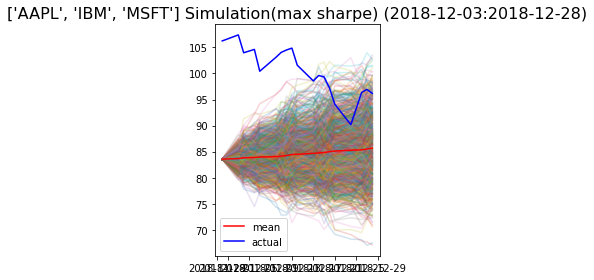

In [150]:
# prepare objects for plotting 
last_train_date = train.index[-1].date()
first_test_date = test.index[0].date()
last_test_date = test.index[-1].date()
plot_title = (f'{RISKY_ASSETS} Simulation(max sharpe) '
              f'({first_test_date}:{last_test_date})')

selected_indices = port_prices[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations), 
                                  index=index)

# plotting
ax = gbm_simulations_df.plot(alpha=0.2, legend=False)
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, port_prices[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('mean', 'actual'))

plt.tight_layout()
#plt.savefig('images/ch6_im2.png')
plt.show()

In [136]:
prices_df['Adj Close']
port_weights1 = min_vol_portf.x
port_prices1 = pd.Series(np.dot(port_weights1, prices_df['Adj Close'].T), 
                              index=prices_df.index)
returns1 = port_prices.pct_change().dropna()

In [137]:
T = len(test)
N = len(test) 
s_0 = port_prices1[train.index[-1]]
N_SIM = 1000
mu = train.mean()
sigma = train.std()


In [138]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, 
                 random_seed=42):
    '''
    Function used for simulating stock returns using Geometric Brownian Motion.
    
    Parameters
    ------------
    s_0 : float
        Initial stock price
    mu : float
        Drift coefficient
    sigma : float
        Diffusion coefficient
    n_sims : int
        Number of simulations paths
    dt : float
        Time increment, most commonly a day
    T : float
        Length of the forecast horizon, same unit as dt
    N : int
        Number of time increments in the forecast horizon
    random_seed : int
        Random seed for reproducibility

    Returns
    -----------
    S_t : np.ndarray
        Matrix (size: n_sims x (T+1)) containing the simulation results. 
        Rows respresent sample paths, while columns point of time.
    '''
    np.random.seed(random_seed)

    dt = T/N 
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis =1)

    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))

    S_t = s_0 * np.exp((mu - 0.5 * sigma ** 2) * time_steps
                       + sigma * W)
    S_t = np.insert(S_t, 0, s_0, axis=1)

    return S_t

In [139]:
gbm_simulations = simulate_gbm(s_0, mu, sigma, N_SIM, T, N)

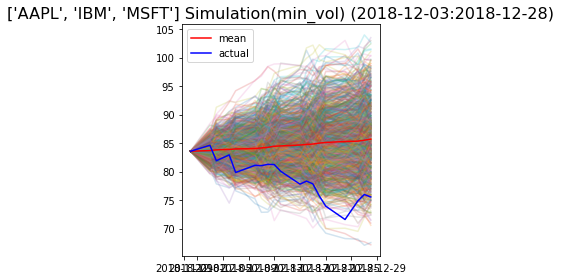

In [148]:
# prepare objects for plotting 
last_train_date = train.index[-1].date()
first_test_date = test.index[0].date()
last_test_date = test.index[-1].date()
plot_title = (f'{RISKY_ASSETS} Simulation(min_vol) '
              f'({first_test_date}:{last_test_date})')

selected_indices = port_prices[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations), 
                                  index=index)

# plotting
ax = gbm_simulations_df.plot(alpha=0.2, legend=False)
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, port_prices1[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('mean', 'actual'))

plt.tight_layout()
#plt.savefig('images/ch6_im2.png')
plt.show()